In [1]:
from sympy import *
import numpy as np
from sympy import symbols, Function, integrate, diff
from scipy.special import airy
from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sys
sys.path.append('../../')
import RandomMatrix as RM

%matplotlib inline
sns.set()

np.random.seed(140)
random.seed(140)

# Defining the Tracy Widom distribution

The Tracy-Widom distribution was defined by Craig A. Tracy and Harold Widom in their paper [*On Orthogonal and Symplectic Matrix Ensembles*](https://arxiv.org/abs/solv-int/9509007). It is an important distribution for studying the distribution of the fluctuations of the maximum eigenvalue of a Gaussian Ensemble. Each Gaussian ensemble has a corresponding Tracy Widom distribution. We will denote the Tracy Widom distribution for Gaussian Ensemble with Dyson index $\beta$ as $TW_\beta$. Let us study the distribution before its application.

Suppose $q$ is the solution to the Painlevé differential equation

$$q'' = sq + 2q^3 $$

with the boundry condition $q \sim Ai(s)$ as $s \rightarrow \infty$. Define $I(t)$ and $J(t)$ to be the following

$$I(t) = - \int_{t}^{\infty} (x-t) q^2(x) dx$$

$$J(t) = \int_{t}^{\infty} q(x) dx$$

If we define $F_\beta$ to be the CDF of $TW_\beta$ then 

$$F_2(t) = e^{I(t)}$$

$$F_1(t) = \sqrt{F_2(t) e^{-J(t)}} $$




# Density of Tracy Widom

To solve for the density of the Tracy Widom we would need to solve for a closed form solution to the Painlevé differential equation. We will instead approximate the curve using the Scipy's ODE solver. In order to define an initial condition, let $t_0$ be a large value so that the condition $q(t_0) = \text{Ai}(t_0)$ approximates our asymptotic boundry condition well. Using the Fundamental Theorem of Calculus, we can differentiate $I$ and $J$ to make them a solution to a differential equation our ODE solver can solve.

In [2]:
# Definition of I(t)
t, x = symbols("t x")
q = Function("q")
I = integrate((x-t)*q(x)**2, (x, t, oo))
I

Integral((-t + x)*q(x)**2, (x, t, oo))

In [3]:
# I'(t)
I_prime = diff(integrate((x-t)*q(x)**2, (x, t, oo)), t)
I_prime

Integral(-q(x)**2, (x, t, oo))

In [4]:
# I''(t)
I_prime2 = diff(integrate((x-t)*q(x)**2, (x, t, oo)), t, 2)
I_prime2

q(t)**2

Thus we can solve for $I(t)$ by solving for the differential equation

$$ \frac{d}{dt} \begin{pmatrix}
 \text{I}(t)\\
\text{I}'(t)
\end{pmatrix} =
\begin{pmatrix}
 \text{I}'(t)\\
q^2
\end{pmatrix}
$$

such that

$$I(t_0) = - \int_{t_0}^{\infty} (x-t_0) q^2(x) dx $$

In [5]:
J = integrate(q(x), (x, t, oo))
J

Integral(q(x), (x, t, oo))

In [6]:
# J'(t)
diff(J)

-q(t)

Thus we can solve for $J$ by solving

$$ \frac{dJ}{dt} = -q(t)$$

such that 

$$J(t_0) = \int_{t_0}^{\infty} q(x) dx$$

In order to improve accuracy, we will use the solver to simultaneously find the values of $q(t)$, $I(t)$ and $J(t)$ in one system of differential equations. This strategy was suggested by Alan Edelman and Per-Olof Persson in their paper [*Numerical Methods for Eigenvalue Distributions of Random Matrices*](https://arxiv.org/abs/math-ph/0501068). Note that we must now slightly change our initial conditions for $I(t)$ and $J(t)$ to avoid using $q$ (since we won't have an approximation for it yet). Luckly, we decided to choose $t_0$ large enough so that $q(t) \approx \text{Ai}(t)$ for $t \geq t_0$, so we may replace $q$ in our intial conditions with $\text{Ai}$. The system of differential equations becomes 

$$\frac{dy}{dt} = \begin{pmatrix}
q' \\
tq+2q^3 \\
I' \\
q^2 \\
-q
\end{pmatrix}$$

where

$$y = \begin{pmatrix}
q \\
q' \\
I \\
I' \\
J
\end{pmatrix}$$

such that

$$y(t_0) = \begin{pmatrix}
\text{Ai}(t_0) \\
\text{Ai}'(t_0) \\
\int_{t_0}^{\infty} (x-t_0) \text{Ai}^2(x) dx \\
\text{Ai}(t_0)^2 \\
\int_{t_0}^{\infty} \text{Ai}(x) dx
\end{pmatrix} $$

Below we define the function we will pass into the ODE solver

In [7]:
def f(t, y):
    d0 = y[1]
    d1 = t*y[0]+2*y[0]**3
    d2 = y[3]
    d3 = y[0]**2
    d4 = -y[0]
    return np.array([d0, d1, d2, d3, d4])

Set the parameters

In [8]:
t0 = 4
tf = -6

Define the initial condition

In [9]:
y0_0 = airy(t0)[0]
y0_1 = airy(t0)[1]
y0_2 = quad(lambda x: (x-t0)*airy(x)[0]**2, t0, np.inf)[0]
y0_3 = airy(t0)[0]
y0_4 = quad(lambda x: airy(x)[0], t0, np.inf)[0]
y0 = np.array([y0_0, y0_1, y0_2, y0_3, y0_4])

Solve the ODE

In [10]:
sol = solve_ivp(f, (t0, tf) ,y0, max_step=.1)

Find the density of $TW_2$

In [11]:
F2 = np.exp(-sol.y[2])
f2 = -sol.y[3] * F2

Find the density of $TW_1$

In [12]:
F1 = np.sqrt(F2 * np.exp(-sol.y[4]))
f1 = 1/(2*F1)*(f2+sol.y[0]*F2)*np.exp(-sol.y[4])

Plot the densities

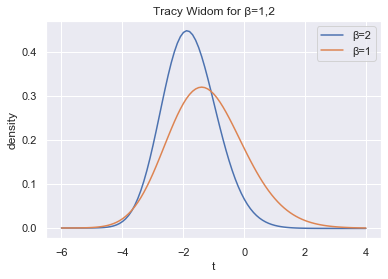

In [13]:
plt.plot(sol.t, f2, label="β=2")
plt.plot(sol.t, f1, label="β=1")
plt.xlabel("t")
plt.ylabel("density")
plt.title("Tracy Widom for β=1,2")
plt.legend();

# Simulation

Tracy and Widom derived the distribution in their paper and proved its relationship to the fluctuations of the largest eigenvalue of Gaussian ensembles. Let the CDF for the $N \times N$ Gaussian ensemble with Dyson index $\beta$ be denoted as $F_{N, \beta}$. Also define $F_\beta$ and $f_\beta$ to be the CDF and density of the Tracy Widom distribution for Dyson index $\beta$ respectively. Tracy and Widom proved the following theorem 

$$ F_\beta(s) = \lim_{N \rightarrow \infty} F_{N, \beta} \left(2 \sigma \sqrt{N} + \frac{\sigma s}{N^{1/6}} \right)$$

We can take the derivative to find the density of the distribution

$$
\begin{align}
\begin{aligned}
f_\beta(s) &= \lim_{N \rightarrow \infty} f_{N,\beta} \left(2 \sigma \sqrt{N} + \frac{\sigma s}{N^{1/6}} \right) \frac{\sigma}{N^{1/6}} \\\\
&= \lim_{N \rightarrow \infty} f_{N, \beta} \left(\frac{s+2\sqrt{N}N^{1/6}}{\frac{N^{1/6}}{\sigma}} \right) \frac{1}{\frac{N^{1/6}}{\sigma}}
\end{aligned}
\end{align}
$$


Recall the formula for the density of linear transformations $f_{aX+b}(s) = f_{X}(\frac{s-b}{a}) \frac{1}{|a|}$. This implies that if $\lambda_{\max}$ is the greatest eigenvalue and $\sigma$ is the standard deviation of it's off diagonals, then 

$$\lim_{N \rightarrow \infty} \frac{N^{1/6}}{\sigma} \lambda_{\max} - 2 \sqrt{N} N^{1/6} \sim \text{Tracy Widom}_{\beta}$$




# Simulation

## GOE

Recall from the first chapter the off diagonal terms in a GOE have standard deviation $\frac{1}{\sqrt{2}}$

In [14]:
trials = 10000
GOE_samples = []
N = 400
σ = 1/(np.sqrt(2))
for _ in range(trials):
    A = RM.Generate_GOE(N)
    λs = np.linalg.eigvals(A)
    λ_max = max(λs)
    GOE_samples.append(N**(1/6) * (λ_max/σ - 2*np.sqrt(N)))

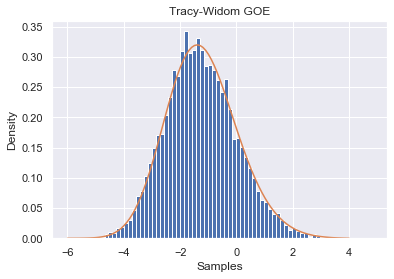

In [15]:
plt.ylabel("Density")
plt.xlabel("Samples")
plt.title("Tracy-Widom GOE")
plt.hist(GOE_samples, bins=70, density=True)
plt.plot(sol.t, f1);

## GUE

Recall from the first chapter that the off diagonal terms of a GUE have standard deviation 1.

In [16]:
trials = 30000
GUE_samples = []
N = 100
σ = 1
for _ in range(trials):
    A = RM.Generate_GUE(N)
    λs, V = np.linalg.eigh(A)
    λ_max = max(λs)
    GUE_samples.append(N**(1/6)*(λ_max/σ - 2*np.sqrt(N)))

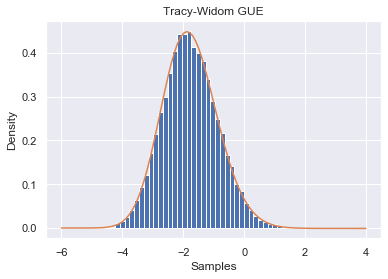

In [17]:
plt.ylabel("Density")
plt.xlabel("Samples")
plt.title("Tracy-Widom GUE")
plt.hist(GUE_samples, bins=50, density=True)
plt.plot(sol.t, f2);

# Longest Increasing Subsequence

The Tracy Widom distribution suprisingly arises when studying sequences, as explained in [On the Distribution of the Length of the Longest Increasing Subsequence of Random Permutations](https://arxiv.org/abs/math/9810105) by Jinho Baik, Percy Deift, and Kurt Johansson. Let $S_N$ be the group of permutations of $1,2,3,...,N$. Define $\ell_N(\pi)$ to be the longest monotone increasing subsequence $\pi \in S_n$. Then

$$ \frac{\ell_N - 2\sqrt{N}}{N^{1/6}} \longrightarrow TW_2$$ 

as $N \longrightarrow \infty$. 

Below we sample from $S_N$, measure their lengths and plot the normalized distribution where $N=5000$.

In [18]:
def longest_increasing_subsequence(X):
    # https://en.wikipedia.org/wiki/Longest_increasing_subsequence#Efficient_algorithms
    """Returns the Longest Increasing Subsequence in the Given List/Array"""
    N = len(X)
    P = [0] * N
    M = [0] * (N+1)
    L = 0
    for i in range(N):
        lo = 1
        hi = L
        while lo <= hi:
            mid = (lo+hi)//2
            if (X[M[mid]] < X[i]):
                lo = mid+1
            else:
                hi = mid-1
        newL = lo
        P[i] = M[newL-1]
        M[newL] = i
        if (newL > L):
            L = newL
    return L

def sample_random_perm_lens(N, sample_size):
    lengths = []
    numbers = np.arange(1, N+1)
    for _ in range(sample_size):
        random.shuffle(numbers)
        lengths.append(longest_increasing_subsequence(numbers))
    return lengths

In [19]:
N = 5000
sample_size = 10000
perm_lens = sample_random_perm_lens(N, sample_size)
χ = (perm_lens - 2*np.sqrt(N))/N**(1/6)

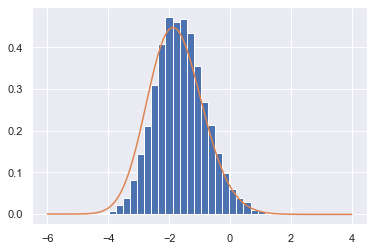

In [20]:
plt.hist(χ, bins=28, density=True)
plt.plot(sol.t, f2, label="β=2");

We expect the bias to be corrected as we increase $N$, but that may be very computationally expensive.